In [1]:
!pip install tensorflow
!pip install imutils

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [2]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Input, ZeroPadding2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
import cv2
import imutils
import numpy as np
import matplotlib.pyplot as plt
import time
from os import listdir

%matplotlib inline

In [3]:
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

# Define paths
input_base_dir = 'archive'
output_base_dir = 'dataset1'
categories = {'yes': 15, 'no': 18}

# Create output directories if they do not exist
for category in categories:
    os.makedirs(os.path.join(output_base_dir, category), exist_ok=True)

# Define the data augmentation generator
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    brightness_range=(0.3, 1.0),
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True, 
    fill_mode='nearest'
)

# Function to augment and save images
def augment_and_save(input_dir, output_dir, category, num_augmented_images):
    for img_name in os.listdir(input_dir):
        img_path = os.path.join(input_dir, img_name)
        img = load_img(img_path)  # Load image
        x = img_to_array(img)  # Convert image to numpy array
        x = x.reshape((1,) + x.shape)  # Reshape image
        
        i = 0
        # Generate and save the specified number of augmented images per original image
        for batch in datagen.flow(x, batch_size=1, save_to_dir=output_dir, save_prefix=category, save_format='jpeg'):
            i += 1
            if i >= num_augmented_images:
                break  # Stop after generating the specified number of images

# Perform augmentation for each category
for category, num_images in categories.items():
    input_dir = os.path.join(input_base_dir, category)
    output_dir = os.path.join(output_base_dir, category)
    augment_and_save(input_dir, output_dir, category, num_images)

print("Data augmentation completed.")


Data augmentation completed.


In [4]:
import os
import cv2
import numpy as np
from matplotlib import pyplot as plt

def crop_brain_contour(image, plot=False):
    # Convert the image to grayscale and blur it slightly
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)

    # Threshold the image, then perform a series of erosions and dilations to remove any small regions of noise
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    # Find contours in the thresholded image, then grab the largest one
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]
    c = max(cnts, key=cv2.contourArea)

    # Find the extreme points
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])

    # Crop new image out of the original image using the four extreme points (left, right, top, bottom)
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]            

    if plot:
        plt.figure()
        plt.subplot(1, 2, 1)
        plt.imshow(image)

        plt.tick_params(axis='both', which='both', 
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)

        plt.title('Original Image')

        plt.subplot(1, 2, 2)
        plt.imshow(new_image)

        plt.tick_params(axis='both', which='both', 
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)

        plt.title('Cropped Image')

        plt.show()

    return new_image



In [5]:
import matplotlib.pyplot as plt

# Function definition for crop_brain_contour (already defined in previous conversation)

# Example usage with your dataset
image_path = 'dataset1/yes/yes_0_10.jpeg'
ex_img = cv2.imread(image_path)

if ex_img is not None:
    ex_new_img = crop_brain_contour(ex_img, plot=True)
    plt.show()
else:
    print(f"Failed to load image at path: {image_path}")

Failed to load image at path: dataset1/yes/yes_0_10.jpeg


In [6]:
# Define paths
input_base_dir = 'dataset1'
output_base_dir = 'cropped_dataset1'
categories = ['yes', 'no']

# Create output directories if they do not exist
for category in categories:
    os.makedirs(os.path.join(output_base_dir, category), exist_ok=True)

# Process and save all images in the dataset
for category in categories:
    input_dir = os.path.join(input_base_dir, category)
    output_dir = os.path.join(output_base_dir, category)

    for img_name in os.listdir(input_dir):
        img_path = os.path.join(input_dir, img_name)
        image = cv2.imread(img_path)
        
        if image is not None:
            cropped_image = crop_brain_contour(image)
            save_path = os.path.join(output_dir, img_name)
            cv2.imwrite(save_path, cropped_image)

print("Brain contour cropping completed.")


Brain contour cropping completed.


In [7]:
import os
import numpy as np
import cv2
from sklearn.utils import shuffle

def load_data(dir_list, image_size):
    """ 
    Arguments:
        dir_list: list of strings representing file directories.
        image_size: tuple representing the dimensions to resize images to.
    Returns:
        X: A numpy array with shape = (#_examples, image_width, image_height, #_channels)
        y: A numpy array with shape = (#_examples, 1)
    """

    # Initialize lists to store images and labels
    X = []
    y = []
    image_width, image_height = image_size
    
    for directory in dir_list:
        for filename in os.listdir(directory):
            # Load the image
            image_path = os.path.join(directory, filename)
            image = cv2.imread(image_path)
            
            if image is not None:
                # Resize image
                image = cv2.resize(image, dsize=(image_width, image_height), interpolation=cv2.INTER_CUBIC)
                # Normalize values
                image = image / 255.0
                # Convert image to numpy array and append it to X
                X.append(image)
                # Append a value of 1 to the target array if the image
                # is in the folder named 'yes', otherwise append 0.
                if 'yes' in directory:
                    y.append([1])
                else:
                    y.append([0])
            else:
                print(f"Failed to load image at path: {image_path}")
                
    X = np.array(X)
    y = np.array(y)
    
    # Shuffle the data
    X, y = shuffle(X, y)
    
    print(f'Number of examples is: {len(X)}')
    print(f'X shape is: {X.shape}')
    print(f'y shape is: {y.shape}')
    
    return X, y


In [8]:
dir_list = ['cropped_dataset1/yes', 'cropped_dataset1/no']
image_size = (240, 240)
X, y = load_data(dir_list, image_size)

Number of examples is: 3660
X shape is: (3660, 240, 240, 3)
y shape is: (3660, 1)


In [9]:
def plot_sample_images(X, y, n=50):
    """
    Plots n sample images for both values of y (labels).
    Arguments:
        X: A numpy array with shape = (#_examples, image_width, image_height, #_channels)
        y: A numpy array with shape = (#_examples, 1)
    """
    
    for label in [0,1]:
        # grab the first n images with the corresponding y values equal to label
        images = X[np.argwhere(y == label)]
        n_images = images[:n]
        
        columns_n = 10
        rows_n = int(n/ columns_n)

        plt.figure(figsize=(20, 10))
        
        i = 1 # current plot        
        for image in n_images:
            plt.subplot(rows_n, columns_n, i)
            plt.imshow(image[0])
            
            # remove ticks
            plt.tick_params(axis='both', which='both', 
                            top=False, bottom=False, left=False, right=False,
                           labelbottom=False, labeltop=False, labelleft=False, labelright=False)
            
            i += 1
        
        label_to_str = lambda label: "Yes" if label == 1 else "No"
        plt.suptitle(f"Brain Tumor: {label_to_str(label)}")
        plt.show()

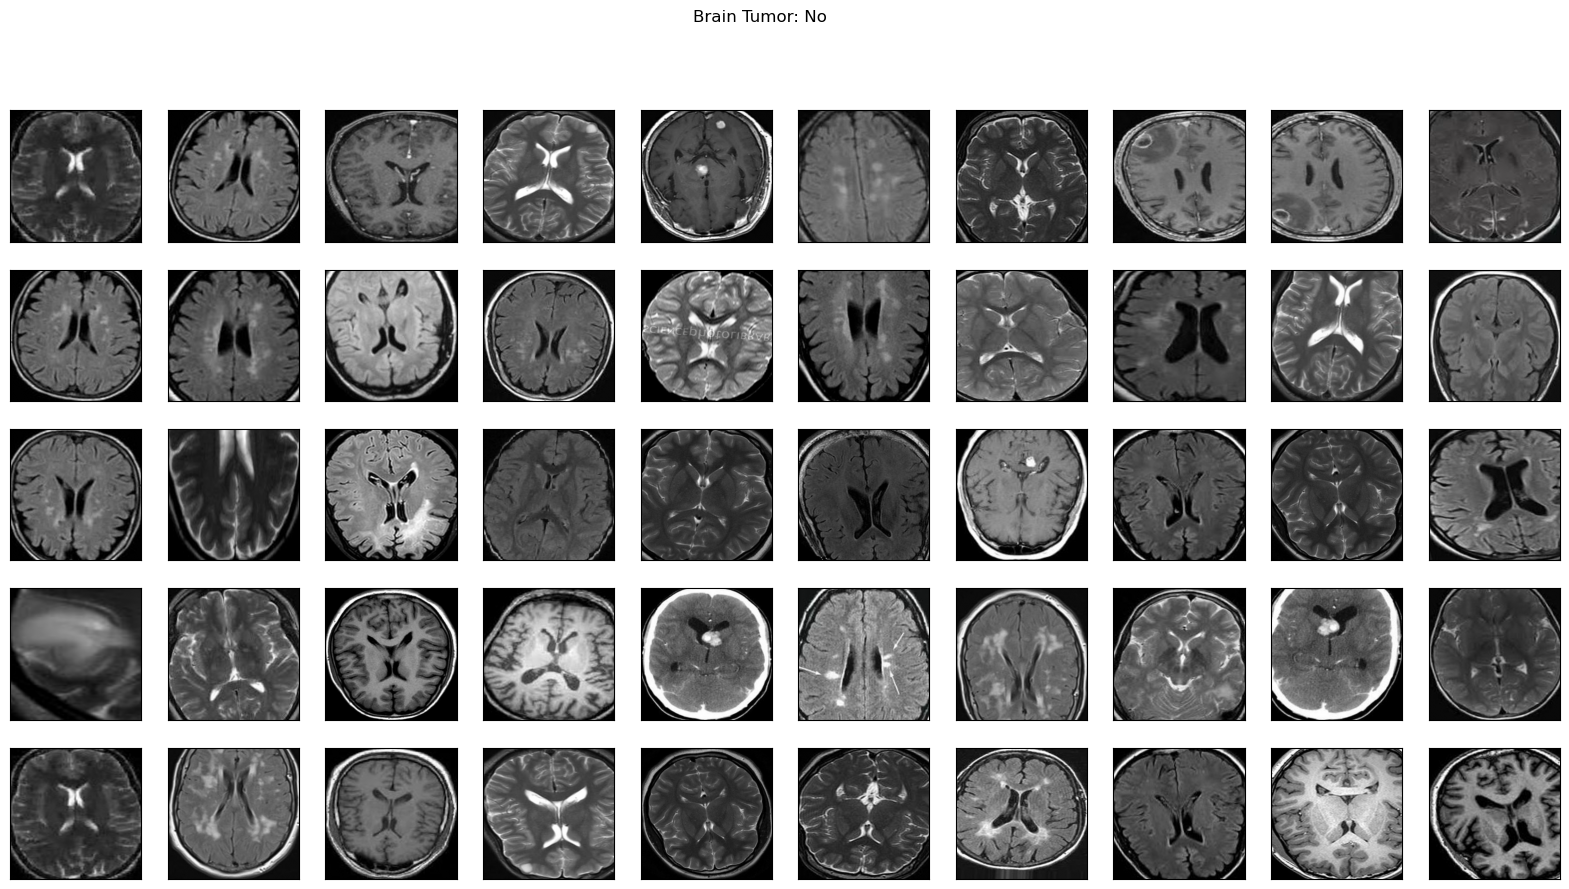

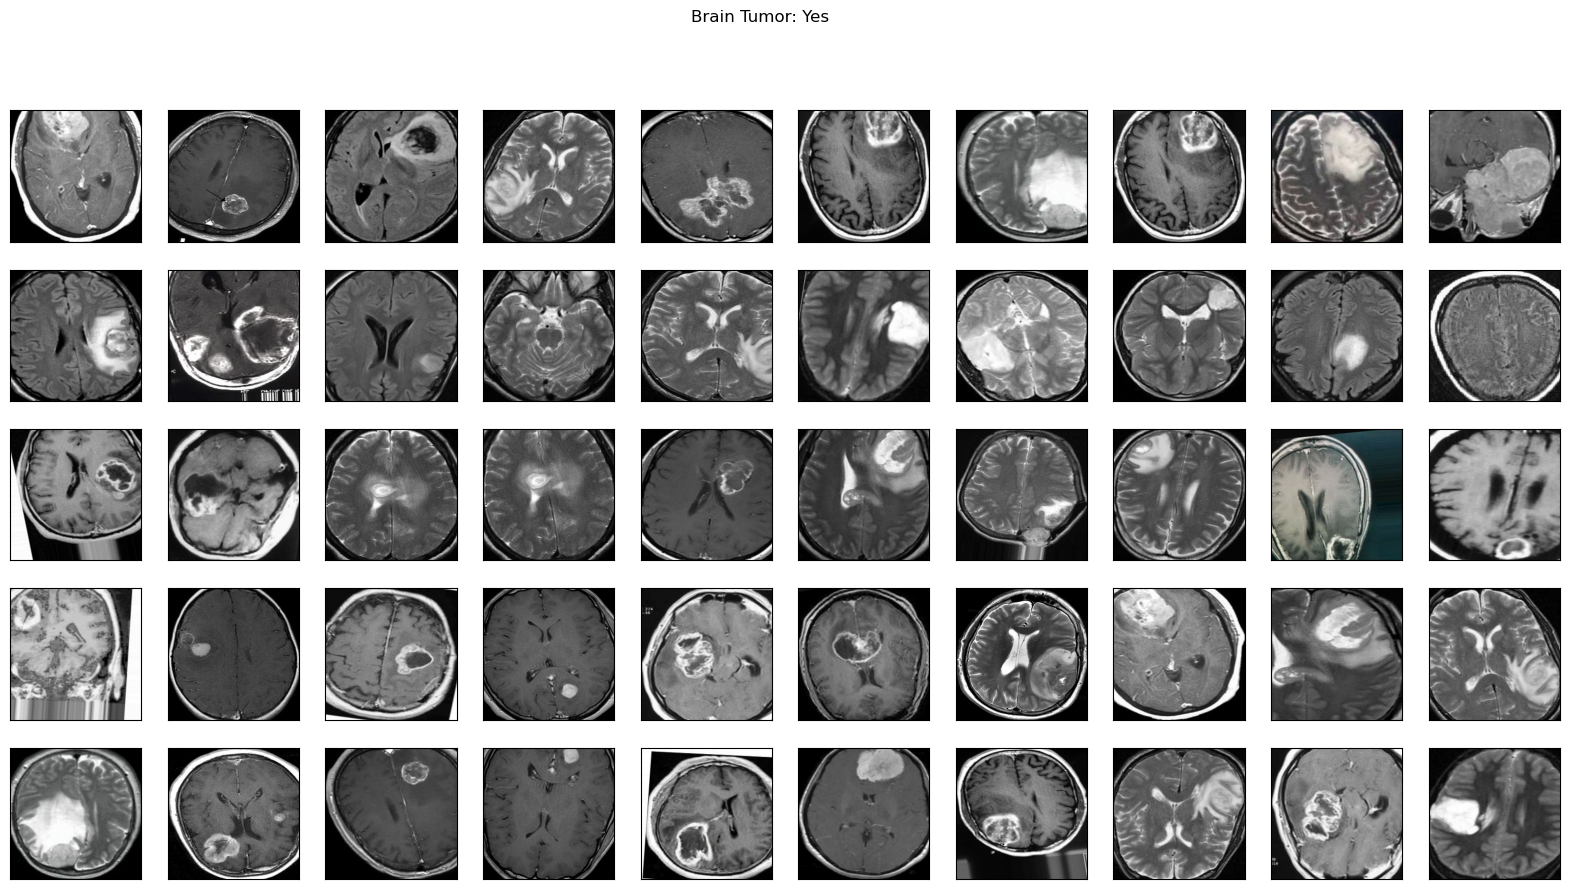

In [10]:
plot_sample_images(X, y)

In [11]:
def split_data(X, y, test_size=0.2):
       
    """
    Splits data into training, development and test sets.
    Arguments:
        X: A numpy array with shape = (#_examples, image_width, image_height, #_channels)
        y: A numpy array with shape = (#_examples, 1)
    Returns:
        X_train: A numpy array with shape = (#_train_examples, image_width, image_height, #_channels)
        y_train: A numpy array with shape = (#_train_examples, 1)
        X_val: A numpy array with shape = (#_val_examples, image_width, image_height, #_channels)
        y_val: A numpy array with shape = (#_val_examples, 1)
        X_test: A numpy array with shape = (#_test_examples, image_width, image_height, #_channels)
        y_test: A numpy array with shape = (#_test_examples, 1)
    """
    
    X_train, X_test_val, y_train, y_test_val = train_test_split(X, y, test_size=test_size)
    X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val, test_size=0.5)
    
    return X_train, y_train, X_val, y_val, X_test, y_test

In [12]:
X_train, y_train, X_val, y_val, X_test, y_test = split_data(X, y, test_size=0.3)

In [13]:
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of development examples = " + str(X_val.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(y_train.shape))
print ("X_val (dev) shape: " + str(X_val.shape))
print ("Y_val (dev) shape: " + str(y_val.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(y_test.shape))

number of training examples = 2562
number of development examples = 549
number of test examples = 549
X_train shape: (2562, 240, 240, 3)
Y_train shape: (2562, 1)
X_val (dev) shape: (549, 240, 240, 3)
Y_val (dev) shape: (549, 1)
X_test shape: (549, 240, 240, 3)
Y_test shape: (549, 1)


In [14]:
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return f"{h}:{m}:{round(s,1)}"

In [15]:
def compute_f1_score(y_true, prob):
    # convert the vector of probabilities to a target vector
    y_pred = np.where(prob > 0.5, 1, 0)
    
    score = f1_score(y_true, y_pred)
    
    return score

In [41]:
def build_model1(input_shape):
    """
    Arugments:
        input_shape: A tuple representing the shape of the input of the model. shape=(image_width, image_height, #_channels)
    Returns:
        model: A Model object.
    """
    # Define the input placeholder as a tensor with shape input_shape. 
    X_input = Input(input_shape) # shape=(?, 240, 240, 3)
    
    # Zero-Padding: pads the border of X_input with zeroes
    X = ZeroPadding2D((2, 2))(X_input) # shape=(?, 244, 244, 3)
    
    # CONV -> BN -> RELU Block applied to X
    X = Conv2D(32, (7, 7), strides = (1, 1), name = 'conv0')(X)
    X = BatchNormalization(axis = 3, name = 'bn0')(X)
    X = Activation('relu')(X) # shape=(?, 238, 238, 32)
    
    # MAXPOOL
    X = MaxPooling2D((4, 4), name='max_pool0')(X) # shape=(?, 59, 59, 32) 
    
    # MAXPOOL
    X = MaxPooling2D((4, 4), name='max_pool1')(X) # shape=(?, 14, 14, 32)
    
    # FLATTEN X 
    X = Flatten()(X) # shape=(?, 6272)
    # FULLYCONNECTED
    X = Dense(1, activation='sigmoid', name='fc')(X) # shape=(?, 1)
    
    # Create model. This creates your Keras model instance, you'll use this instance to train/test the model.
    model = Model(inputs = X_input, outputs = X, name='BrainDetectionModel')
    
    return model

In [42]:
IMG_SHAPE = (240,240, 3)

In [43]:
model1 = build_model1(IMG_SHAPE)

In [44]:
model1.summary()

Model: "BrainDetectionModel"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 240, 240, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ zero_padding2d (ZeroPadding2D)       │ (None, 244, 244, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv0 (Conv2D)                       │ (None, 238, 238, 32)        │           4,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bn0 (BatchNormalization)             │ (None, 238, 238, 32)        │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 238, 238, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pool0 (MaxPooling2D)             │ (None, 59, 59, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pool1 (MaxPooling2D)             │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 6272)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc (Dense)                           │ (None, 1)                   │           6,273 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,137 (43.50 KB)

 Trainable params: 11,073 (43.25 KB)

 Non-trainable params: 64 (256.00 B)

In [49]:
model1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [50]:
filepath = "models3/cnn-parameters-improvement-{epoch:02d}-{val_accuracy:.2f}.keras"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')


In [51]:
# Define the tensorboard callback
import datetime 
log_dir = "logs3/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard = TensorBoard(log_dir=log_dir, histogram_freq=1)

In [52]:
start_time = time.time()

model1.fit(x=X_train, y=y_train, batch_size=32, epochs=15, validation_data=(X_val, y_val), callbacks=[tensorboard, checkpoint])

end_time = time.time()
execution_time = (end_time - start_time)

def hms_string(sec_elapsed):
    h = int(sec_elapsed // 3600)
    m = int((sec_elapsed % 3600) // 60)
    s = int(sec_elapsed % 60)
    return f"{h}:{m:>02}:{s:>02}"

print(f"Elapsed time: {hms_string(execution_time)}")

Epoch 1/15
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5607 - loss: 1.1853
Epoch 1: val_accuracy improved from -inf to 0.71585, saving model to models3/cnn-parameters-improvement-01-0.72.keras
81/81 ━━━━━━━━━━━━━━━━━━━━ 149s 2s/step - accuracy: 0.5616 - loss: 1.1810 - val_accuracy: 0.7158 - val_loss: 0.6266
Epoch 2/15
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7425 - loss: 0.5293
Epoch 2: val_accuracy did not improve from 0.71585
81/81 ━━━━━━━━━━━━━━━━━━━━ 143s 2s/step - accuracy: 0.7424 - loss: 0.5295 - val_accuracy: 0.6175 - val_loss: 0.6362
Epoch 3/15
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7648 - loss: 0.4896
Epoch 3: val_accuracy did not improve from 0.71585
81/81 ━━━━━━━━━━━━━━━━━━━━ 142s 2s/step - accuracy: 0.7647 - loss: 0.4897 - val_accuracy: 0.7104 - val_loss: 0.5700
Epoch 4/15
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7996 - loss: 0.4469
Epoch 4: val_accuracy did not improve from 0.71585
81/81 ━━━━━━━━━━━━━━━━━━━━ 142s 2s/step - accurac

In [61]:
test_loss2, test_accuracy2 = model1.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy2}")


18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 225ms/step - accuracy: 0.6962 - loss: 0.7102
Test Accuracy: 0.7285974621772766


In [16]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense, GlobalAveragePooling2D
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam

def build_model(input_shape):
    """
    Arguments:
        input_shape: A tuple representing the shape of the input of the model. shape=(image_width, image_height, #_channels)
    Returns:
        model: A Model object.
    """
    # Load the VGG16 model pretrained on ImageNet data
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

    # Freeze all layers in the base model
    for layer in base_model.layers:
        layer.trainable = False

    # Add custom top layers for your specific classification task
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)  # Add more dense layers if needed
    predictions = Dense(1, activation='sigmoid')(x)  # Output layer for binary classification

    # Define the full model
    model = Model(inputs=base_model.input, outputs=predictions, name='BrainDetectionModel')


    return model


In [17]:
input_shape = (240, 240, 3)  # Adjust this according to your input image shape
model = build_model(input_shape)


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 10s 0us/step


In [18]:
model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

In [19]:
filepath = "models1/cnn-parameters-improvement-{epoch:02d}-{val_accuracy:.2f}.keras"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')


In [20]:
# Define the tensorboard callback
import datetime 
log_dir = "logs1/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard = TensorBoard(log_dir=log_dir, histogram_freq=1)

In [21]:
start_time = time.time()
history = model.fit(X_train, y_train, batch_size=32, epochs=15, validation_data=(X_val, y_val), callbacks=[tensorboard, checkpoint])
end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {execution_time} seconds")

Epoch 1/15
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.5768 - loss: 0.6751
Epoch 1: val_accuracy improved from -inf to 0.67395, saving model to models1/cnn-parameters-improvement-01-0.67.keras
81/81 ━━━━━━━━━━━━━━━━━━━━ 327s 4s/step - accuracy: 0.5770 - loss: 0.6749 - val_accuracy: 0.6740 - val_loss: 0.6366
Epoch 2/15
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6584 - loss: 0.6272
Epoch 2: val_accuracy improved from 0.67395 to 0.69763, saving model to models1/cnn-parameters-improvement-02-0.70.keras
81/81 ━━━━━━━━━━━━━━━━━━━━ 348s 4s/step - accuracy: 0.6586 - loss: 0.6270 - val_accuracy: 0.6976 - val_loss: 0.6082
Epoch 3/15
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.6927 - loss: 0.5946
Epoch 3: val_accuracy improved from 0.69763 to 0.70128, saving model to models1/cnn-parameters-improvement-03-0.70.keras
81/81 ━━━━━━━━━━━━━━━━━━━━ 352s 4s/step - accuracy: 0.6929 - loss: 0.5945 - val_accuracy: 0.7013 - val_loss: 0.5875
Epoch 4/15
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 4s

In [22]:
start_time = time.time()
history = model.fit(X_train, y_train, batch_size=28, epochs=10, validation_data=(X_val, y_val), callbacks=[tensorboard, checkpoint])
end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {execution_time} seconds")

Epoch 1/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8483 - loss: 0.3959
Epoch 1: val_accuracy improved from 0.84699 to 0.85428, saving model to models1/cnn-parameters-improvement-01-0.85.keras
92/92 ━━━━━━━━━━━━━━━━━━━━ 365s 4s/step - accuracy: 0.8483 - loss: 0.3959 - val_accuracy: 0.8543 - val_loss: 0.4021
Epoch 2/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8481 - loss: 0.3910
Epoch 2: val_accuracy improved from 0.85428 to 0.86703, saving model to models1/cnn-parameters-improvement-02-0.87.keras
92/92 ━━━━━━━━━━━━━━━━━━━━ 356s 4s/step - accuracy: 0.8481 - loss: 0.3909 - val_accuracy: 0.8670 - val_loss: 0.3900
Epoch 3/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8624 - loss: 0.3834
Epoch 3: val_accuracy improved from 0.86703 to 0.87067, saving model to models1/cnn-parameters-improvement-03-0.87.keras
92/92 ━━━━━━━━━━━━━━━━━━━━ 351s 4s/step - accuracy: 0.8624 - loss: 0.3832 - val_accuracy: 0.8707 - val_loss: 0.3871
Epoch 4/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s

In [23]:
start_time = time.time()
history = model.fit(X_train, y_train, batch_size=28, epochs=10, validation_data=(X_val, y_val), callbacks=[tensorboard, checkpoint])
end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

Epoch 1/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8966 - loss: 0.3018
Epoch 1: val_accuracy did not improve from 0.90346
92/92 ━━━━━━━━━━━━━━━━━━━━ 372s 4s/step - accuracy: 0.8966 - loss: 0.3019 - val_accuracy: 0.8761 - val_loss: 0.3265
Epoch 2/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8737 - loss: 0.3200
Epoch 2: val_accuracy did not improve from 0.90346
92/92 ━━━━━━━━━━━━━━━━━━━━ 361s 4s/step - accuracy: 0.8739 - loss: 0.3199 - val_accuracy: 0.9035 - val_loss: 0.3206
Epoch 3/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8808 - loss: 0.3130
Epoch 3: val_accuracy improved from 0.90346 to 0.91257, saving model to models1/cnn-parameters-improvement-03-0.91.keras
92/92 ━━━━━━━━━━━━━━━━━━━━ 362s 4s/step - accuracy: 0.8810 - loss: 0.3129 - val_accuracy: 0.9126 - val_loss: 0.3100
Epoch 4/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8949 - loss: 0.3049
Epoch 4: val_accuracy did not improve from 0.91257
92/92 ━━━━━━━━━━━━━━━━━━━━ 358s 4s/step - accu

In [24]:
start_time = time.time()
history = model.fit(X_train, y_train, batch_size=28, epochs=10, validation_data=(X_val, y_val), callbacks=[tensorboard, checkpoint])
end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

Epoch 1/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9156 - loss: 0.2634
Epoch 1: val_accuracy did not improve from 0.91985
92/92 ━━━━━━━━━━━━━━━━━━━━ 334s 4s/step - accuracy: 0.9156 - loss: 0.2633 - val_accuracy: 0.9180 - val_loss: 0.2719
Epoch 2/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9014 - loss: 0.2600
Epoch 2: val_accuracy improved from 0.91985 to 0.92168, saving model to models1/cnn-parameters-improvement-02-0.92.keras
92/92 ━━━━━━━━━━━━━━━━━━━━ 360s 4s/step - accuracy: 0.9015 - loss: 0.2599 - val_accuracy: 0.9217 - val_loss: 0.2669
Epoch 3/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9161 - loss: 0.2487
Epoch 3: val_accuracy did not improve from 0.92168
92/92 ━━━━━━━━━━━━━━━━━━━━ 353s 4s/step - accuracy: 0.9162 - loss: 0.2487 - val_accuracy: 0.9199 - val_loss: 0.2618
Epoch 4/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9198 - loss: 0.2430
Epoch 4: val_accuracy improved from 0.92168 to 0.92532, saving model to models1/cnn-parameters-im

In [56]:
model.save('vgg16_model.keras')


In [64]:
history = model.history.history

In [65]:
for key in history.keys():
    print(key)

accuracy
loss
val_accuracy
val_loss


In [66]:
def plot_metrics(history):
    
    train_loss = history['loss']
    val_loss = history['val_loss']
    train_acc = history['accuracy']
    val_acc = history['val_accuracy']
    
    # Loss
    plt.figure()
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Loss')
    plt.legend()
    plt.show()
    
    # Accuracy
    plt.figure()
    plt.plot(train_acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.title('Accuracy')
    plt.legend()
    plt.show()

In [69]:
best_model = load_model(filepath='models1/cnn-parameters-improvement-07-0.93.keras')

In [70]:
best_model.metrics_names

['loss', 'compile_metrics']

In [71]:
loss, acc = best_model.evaluate(x=X_test, y=y_test)

18/18 ━━━━━━━━━━━━━━━━━━━━ 58s 3s/step - accuracy: 0.9331 - loss: 0.2227


In [75]:
print (f"Test Loss = {loss}")


Test Loss = 0.22433580458164215


In [73]:
y_test_prob = best_model.predict(X_test)

18/18 ━━━━━━━━━━━━━━━━━━━━ 55s 3s/step


In [74]:
f1score = compute_f1_score(y_test, y_test_prob)
print(f"F1 score: {f1score}")

F1 score: 0.944


In [25]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy}")


18/18 ━━━━━━━━━━━━━━━━━━━━ 68s 4s/step - accuracy: 0.9364 - loss: 0.2125
Test Accuracy: 0.9398906826972961


In [26]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense

def build_resnet_model(input_shape):
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    
    # Add custom layers on top
    x = base_model.output
    x = Flatten()(x)
    predictions = Dense(1, activation='sigmoid')(x)
    
    # Create the full model
    model = Model(inputs=base_model.input, outputs=predictions)
    
    return model


In [27]:
input_shape = (240, 240, 3)

# Build the ResNet50 model
resnet_model = build_resnet_model(input_shape)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 21s 0us/step


In [28]:
for layer in resnet_model.layers[:-4]:
    layer.trainable = False

In [29]:
resnet_model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

In [33]:
filepath = "models2/resnet-parameters-improvement-{epoch:02d}-{val_accuracy:.2f}.keras"
checkpoint_resnet = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')


In [34]:
# Define the tensorboard callback
import datetime 
log_dir = "logs2/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_resnet = TensorBoard(log_dir=log_dir, histogram_freq=1)

In [35]:
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

# Create data generators
train_generator = train_datagen.flow(X_train, y_train, batch_size=32)
val_generator = val_datagen.flow(X_val, y_val, batch_size=32)

# Train the model using generators
start_time = time.time()
history_resnet = resnet_model.fit(train_generator, epochs=15, validation_data=val_generator, callbacks=[tensorboard_resnet, checkpoint_resnet])
end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

Epoch 1/15


C:\Users\Vaibhav\AppData\Roaming\Python\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.5356 - loss: 0.7609
Epoch 1: val_accuracy improved from -inf to 0.57741, saving model to models2/resnet-parameters-improvement-01-0.58.keras
81/81 ━━━━━━━━━━━━━━━━━━━━ 281s 3s/step - accuracy: 0.5355 - loss: 0.7606 - val_accuracy: 0.5774 - val_loss: 0.6883
Epoch 2/15
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.5288 - loss: 0.7067
Epoch 2: val_accuracy did not improve from 0.57741
81/81 ━━━━━━━━━━━━━━━━━━━━ 260s 3s/step - accuracy: 0.5287 - loss: 0.7068 - val_accuracy: 0.5774 - val_loss: 0.7016
Epoch 3/15
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.5049 - loss: 0.7153
Epoch 3: val_accuracy did not improve from 0.57741
81/81 ━━━━━━━━━━━━━━━━━━━━ 264s 3s/step - accuracy: 0.5051 - loss: 0.7153 - val_accuracy: 0.4226 - val_loss: 0.7024
Epoch 4/15
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.5165 - loss: 0.7216
Epoch 4: val_accuracy did not improve from 0.57741
81/81 ━━━━━━━━━━━━━━━━━━━━ 269s 3s/step - accuracy: 0.516

In [36]:
start_time = time.time()
history = resnet_model.fit(X_train, y_train, batch_size=28, epochs=15, validation_data=(X_val, y_val), callbacks=[tensorboard_resnet, checkpoint_resnet])
end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

Epoch 1/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6114 - loss: 0.6679
Epoch 1: val_accuracy improved from 0.57741 to 0.64299, saving model to models2/resnet-parameters-improvement-01-0.64.keras
92/92 ━━━━━━━━━━━━━━━━━━━━ 328s 4s/step - accuracy: 0.6118 - loss: 0.6674 - val_accuracy: 0.6430 - val_loss: 0.6279
Epoch 2/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7138 - loss: 0.5474
Epoch 2: val_accuracy improved from 0.64299 to 0.67031, saving model to models2/resnet-parameters-improvement-02-0.67.keras
92/92 ━━━━━━━━━━━━━━━━━━━━ 284s 3s/step - accuracy: 0.7139 - loss: 0.5473 - val_accuracy: 0.6703 - val_loss: 0.5837
Epoch 3/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7371 - loss: 0.5138
Epoch 3: val_accuracy did not improve from 0.67031
92/92 ━━━━━━━━━━━━━━━━━━━━ 286s 3s/step - accuracy: 0.7371 - loss: 0.5138 - val_accuracy: 0.6667 - val_loss: 0.5756
Epoch 4/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7666 - loss: 0.4893
Epoch 4: val_accuracy

In [37]:
start_time = time.time()
history = resnet_model.fit(X_train, y_train, batch_size=28, epochs=15, validation_data=(X_val, y_val), callbacks=[tensorboard_resnet, checkpoint_resnet])
end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

Epoch 1/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8618 - loss: 0.3565
Epoch 1: val_accuracy did not improve from 0.79781
92/92 ━━━━━━━━━━━━━━━━━━━━ 327s 4s/step - accuracy: 0.8616 - loss: 0.3566 - val_accuracy: 0.7796 - val_loss: 0.4673
Epoch 2/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8276 - loss: 0.4003
Epoch 2: val_accuracy did not improve from 0.79781
92/92 ━━━━━━━━━━━━━━━━━━━━ 311s 3s/step - accuracy: 0.8276 - loss: 0.4002 - val_accuracy: 0.7741 - val_loss: 0.4743
Epoch 3/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8647 - loss: 0.3618
Epoch 3: val_accuracy improved from 0.79781 to 0.80692, saving model to models2/resnet-parameters-improvement-03-0.81.keras
92/92 ━━━━━━━━━━━━━━━━━━━━ 316s 3s/step - accuracy: 0.8645 - loss: 0.3619 - val_accuracy: 0.8069 - val_loss: 0.4612
Epoch 4/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8512 - loss: 0.3671
Epoch 4: val_accuracy improved from 0.80692 to 0.82149, saving model to models2/resnet-paramet

In [38]:
start_time = time.time()
history = resnet_model.fit(X_train, y_train, batch_size=28, epochs=10, validation_data=(X_val, y_val), callbacks=[tensorboard_resnet, checkpoint_resnet])
end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

Epoch 1/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8874 - loss: 0.3069
Epoch 1: val_accuracy did not improve from 0.82696
92/92 ━━━━━━━━━━━━━━━━━━━━ 376s 4s/step - accuracy: 0.8873 - loss: 0.3069 - val_accuracy: 0.8251 - val_loss: 0.4291
Epoch 2/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8757 - loss: 0.3153
Epoch 2: val_accuracy did not improve from 0.82696
92/92 ━━━━━━━━━━━━━━━━━━━━ 383s 4s/step - accuracy: 0.8757 - loss: 0.3153 - val_accuracy: 0.7960 - val_loss: 0.4449
Epoch 3/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.8780 - loss: 0.3215
Epoch 3: val_accuracy did not improve from 0.82696
92/92 ━━━━━━━━━━━━━━━━━━━━ 440s 5s/step - accuracy: 0.8780 - loss: 0.3214 - val_accuracy: 0.8179 - val_loss: 0.4329
Epoch 4/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.8948 - loss: 0.2802
Epoch 4: val_accuracy did not improve from 0.82696
92/92 ━━━━━━━━━━━━━━━━━━━━ 458s 5s/step - accuracy: 0.8948 - loss: 0.2803 - val_accuracy: 0.7887 - val_loss: 0.4561


In [39]:
test_loss1, test_accuracy1 = resnet_model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy1}")


18/18 ━━━━━━━━━━━━━━━━━━━━ 47s 3s/step - accuracy: 0.8196 - loss: 0.4315
Test Accuracy: 0.8233151435852051
